In [1]:
import os
import logging
from pathlib import Path
import datetime

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim
from torchinfo import summary

import torchmetrics

import cv2

import config
import dataset
import dataset_fasdd
import models
import loss
import metrics
import train_epoch
import val_epoch
import utils

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = config.LOGS_FOLDER

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny.\n' +  
            '\tOne Head.\n' +
            '\tWeighted for Precision.\n' +
            '\tModules.\n'+ 
            '\tLosses and Metrics Loggers.\n' +
            '\tMore checkpoints.\n' +
            f'\t{config.EPOCHS} epochs.\n' +
            '\tDataset images divided by 256.\n' +
            '\tFASDD CV and UAV added.\n' +
            '\tAffine True for all BatchNorm Modules: fixed, as I forgot one module in previous experiment.\n')

# View Dataset

### Transform

In [4]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.2),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

VIEW_BATCH_SIZE = 32

### DFire

In [5]:
view_dfire_ds = dataset.DFireDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    img_dir=config.val_imgs, 
    label_dir=config.val_labels, 
    num_classes=config.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_dfire_loader = DataLoader(dataset=view_dfire_ds,
                               batch_size=VIEW_BATCH_SIZE,
                               num_workers=1,
                               pin_memory=True,
                               shuffle=True,
                               drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


### FASDD UAV

In [6]:
view_fasdd_uav_ds = dataset_fasdd.FASDDDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    imgs_dir=config.FASDD_UAV_IMGS_DIR, 
    labels_file=config.FASDD_UAV_TEST_LABELS_FILE, 
    num_classes=config.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_fasdd_uav_loader = DataLoader(dataset=view_fasdd_uav_ds,
                                   batch_size=VIEW_BATCH_SIZE,
                                   num_workers=1,
                                   pin_memory=True,
                                   shuffle=True,
                                   drop_last=False)
print(f'Val dataset length: {len(view_fasdd_uav_ds)}')

DFire Removed wrong images: 0
DFire empty images: 24
DFire only smoke images: 14
DFire only fire images: 0
DFire smoke and fire images: 26
Val dataset length: 64


### FASDD CV

In [7]:
view_fasdd_cv_ds = dataset_fasdd.FASDDDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    imgs_dir=config.FASDD_CV_IMGS_DIR, 
    labels_file=config.FASDD_CV_TEST_LABELS_FILE, 
    num_classes=config.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_fasdd_cv_loader = DataLoader(dataset=view_fasdd_cv_ds,
                                   batch_size=VIEW_BATCH_SIZE,
                                   num_workers=1,
                                   pin_memory=True,
                                   shuffle=True,
                                   drop_last=False)
print(f'Val dataset length: {len(view_fasdd_cv_ds)}')

DFire Removed wrong images: 0
DFire empty images: 30
DFire only smoke images: 15
DFire only fire images: 7
DFire smoke and fire images: 12
Val dataset length: 64


# Plot Dataset Pictures

### DFire

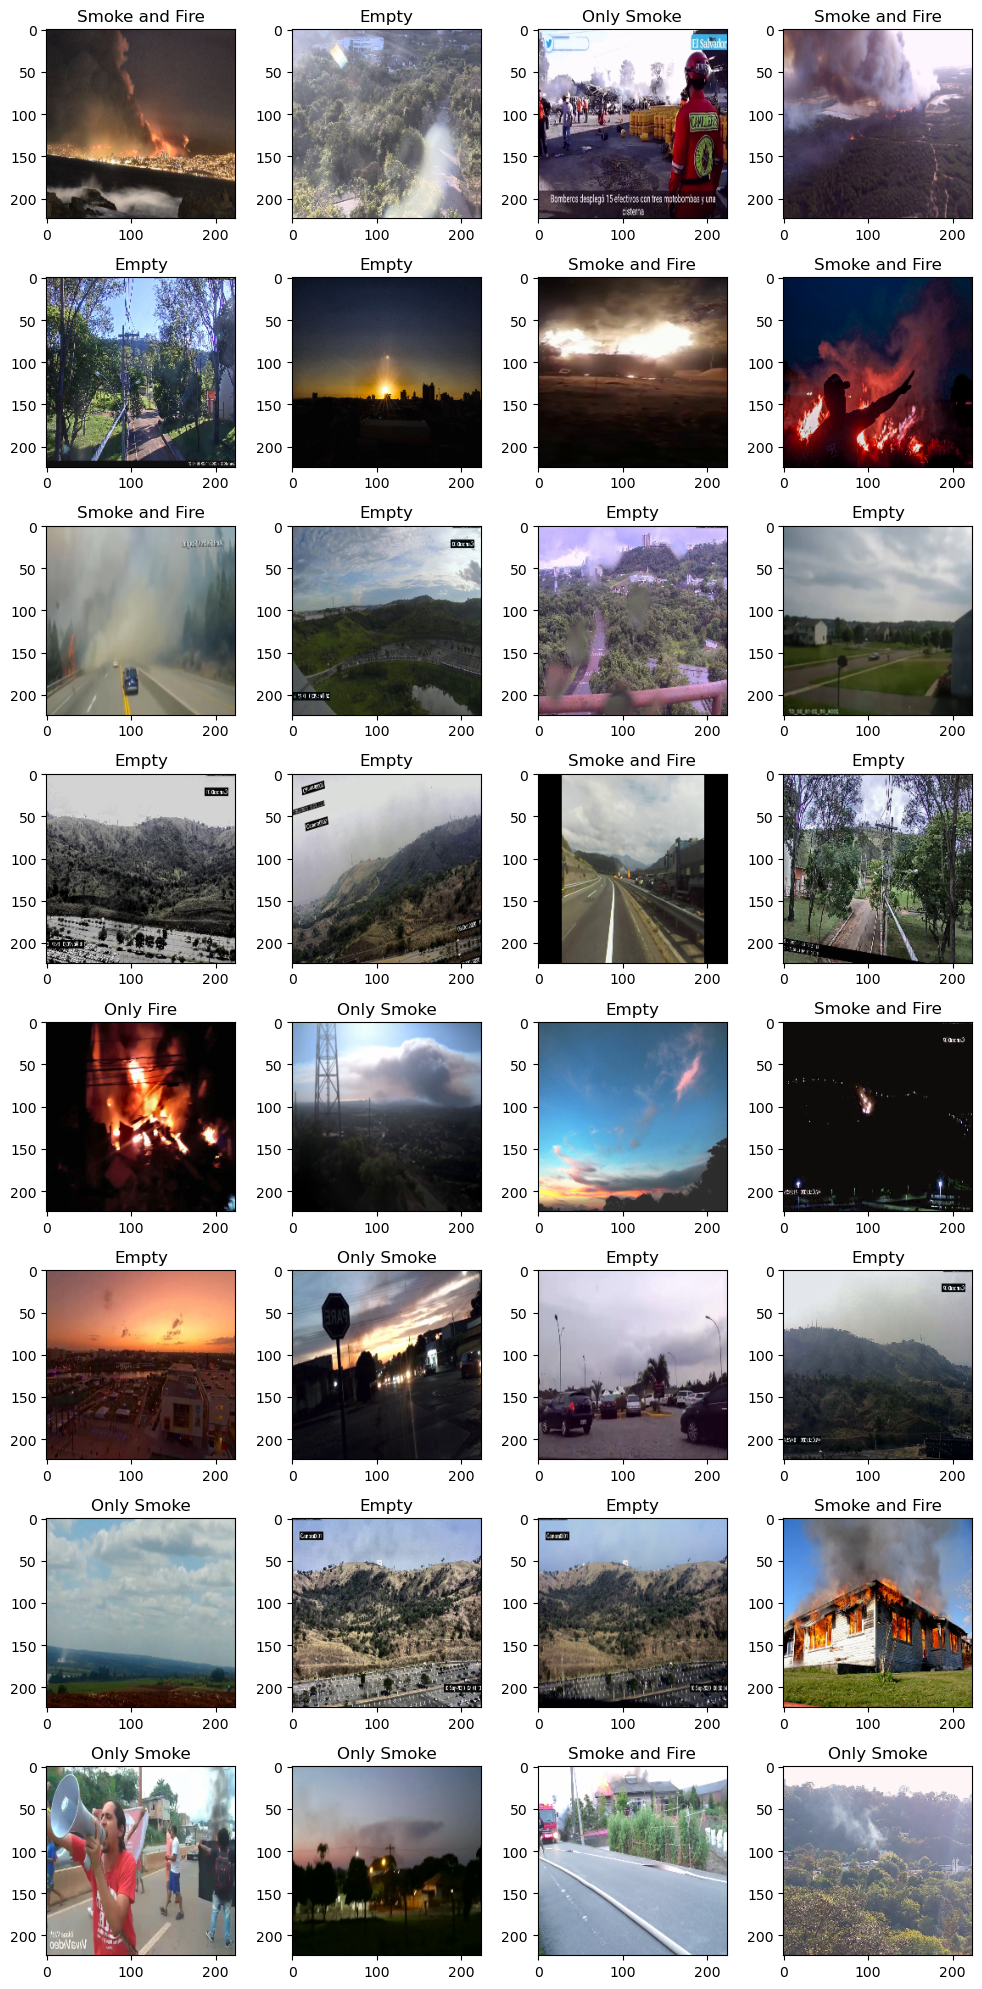

In [8]:
for i, (img, label) in enumerate(view_dfire_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

### FASDD UAV

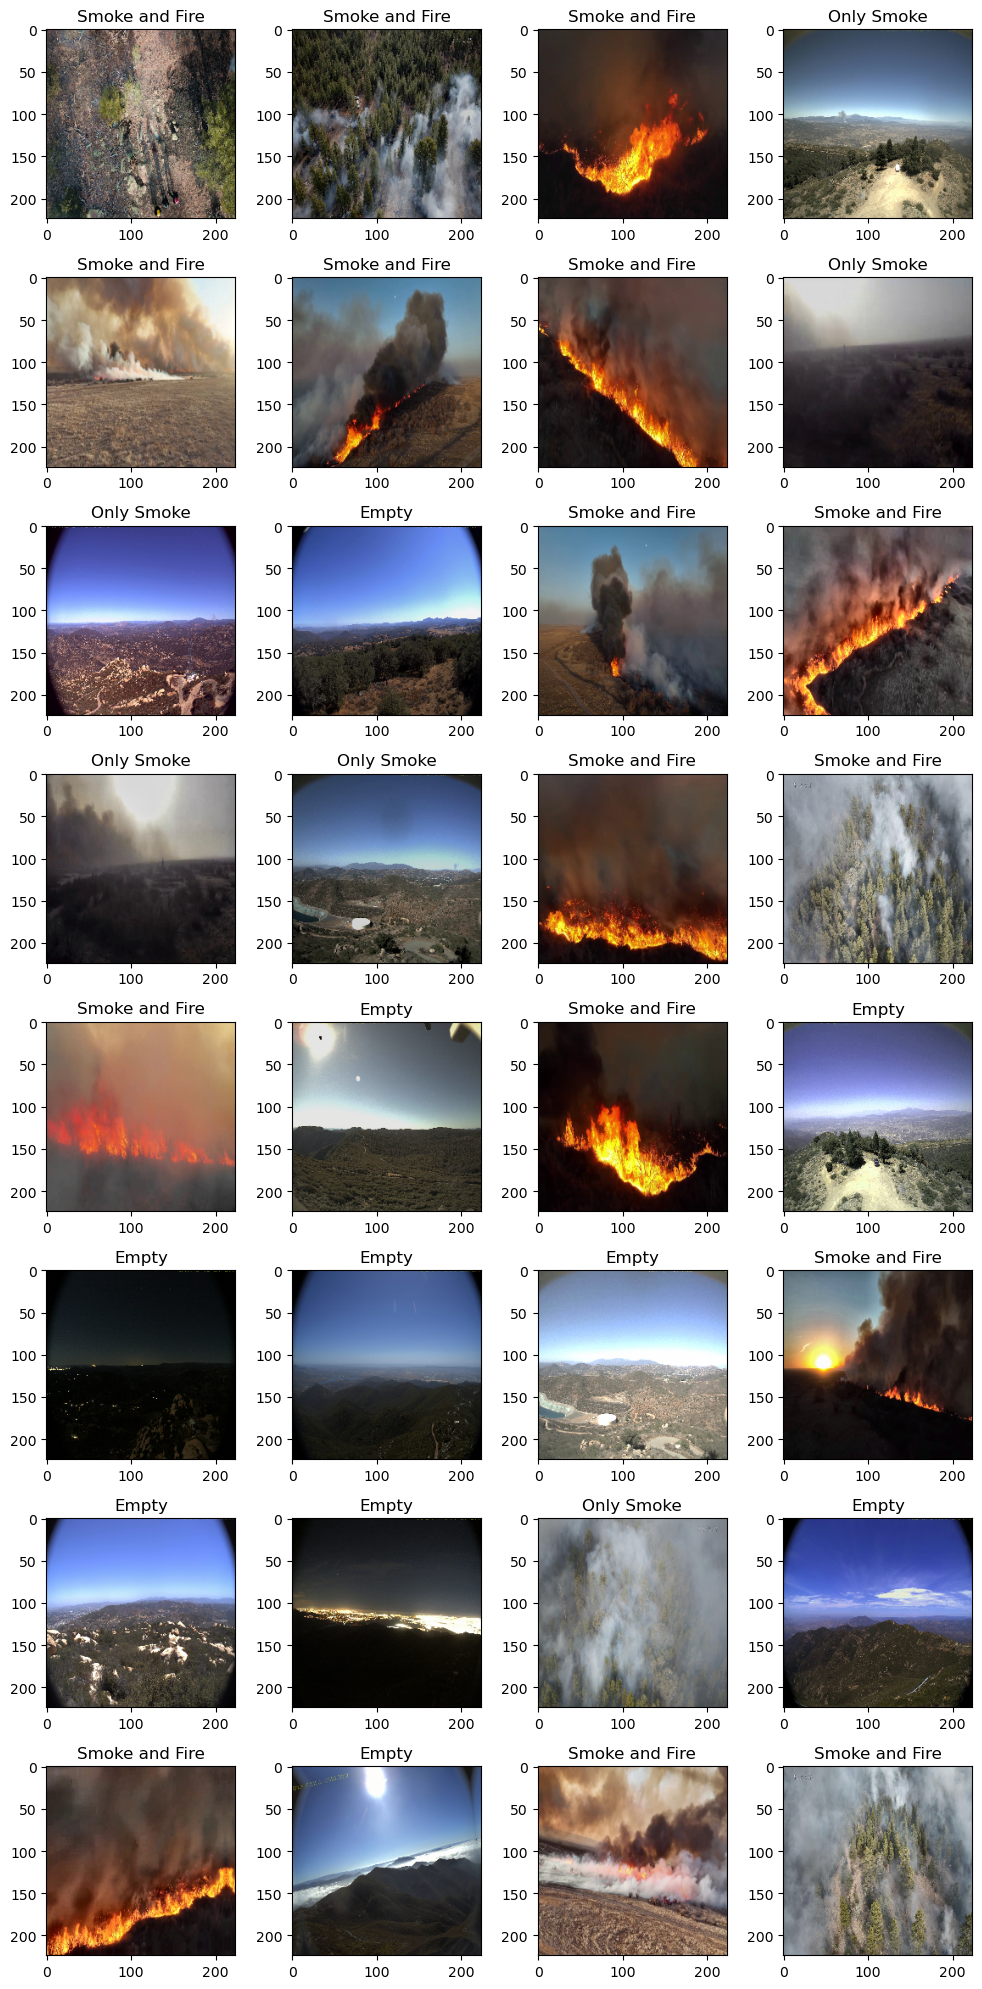

In [9]:
for i, (img, label) in enumerate(view_fasdd_uav_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

### FASDD CV

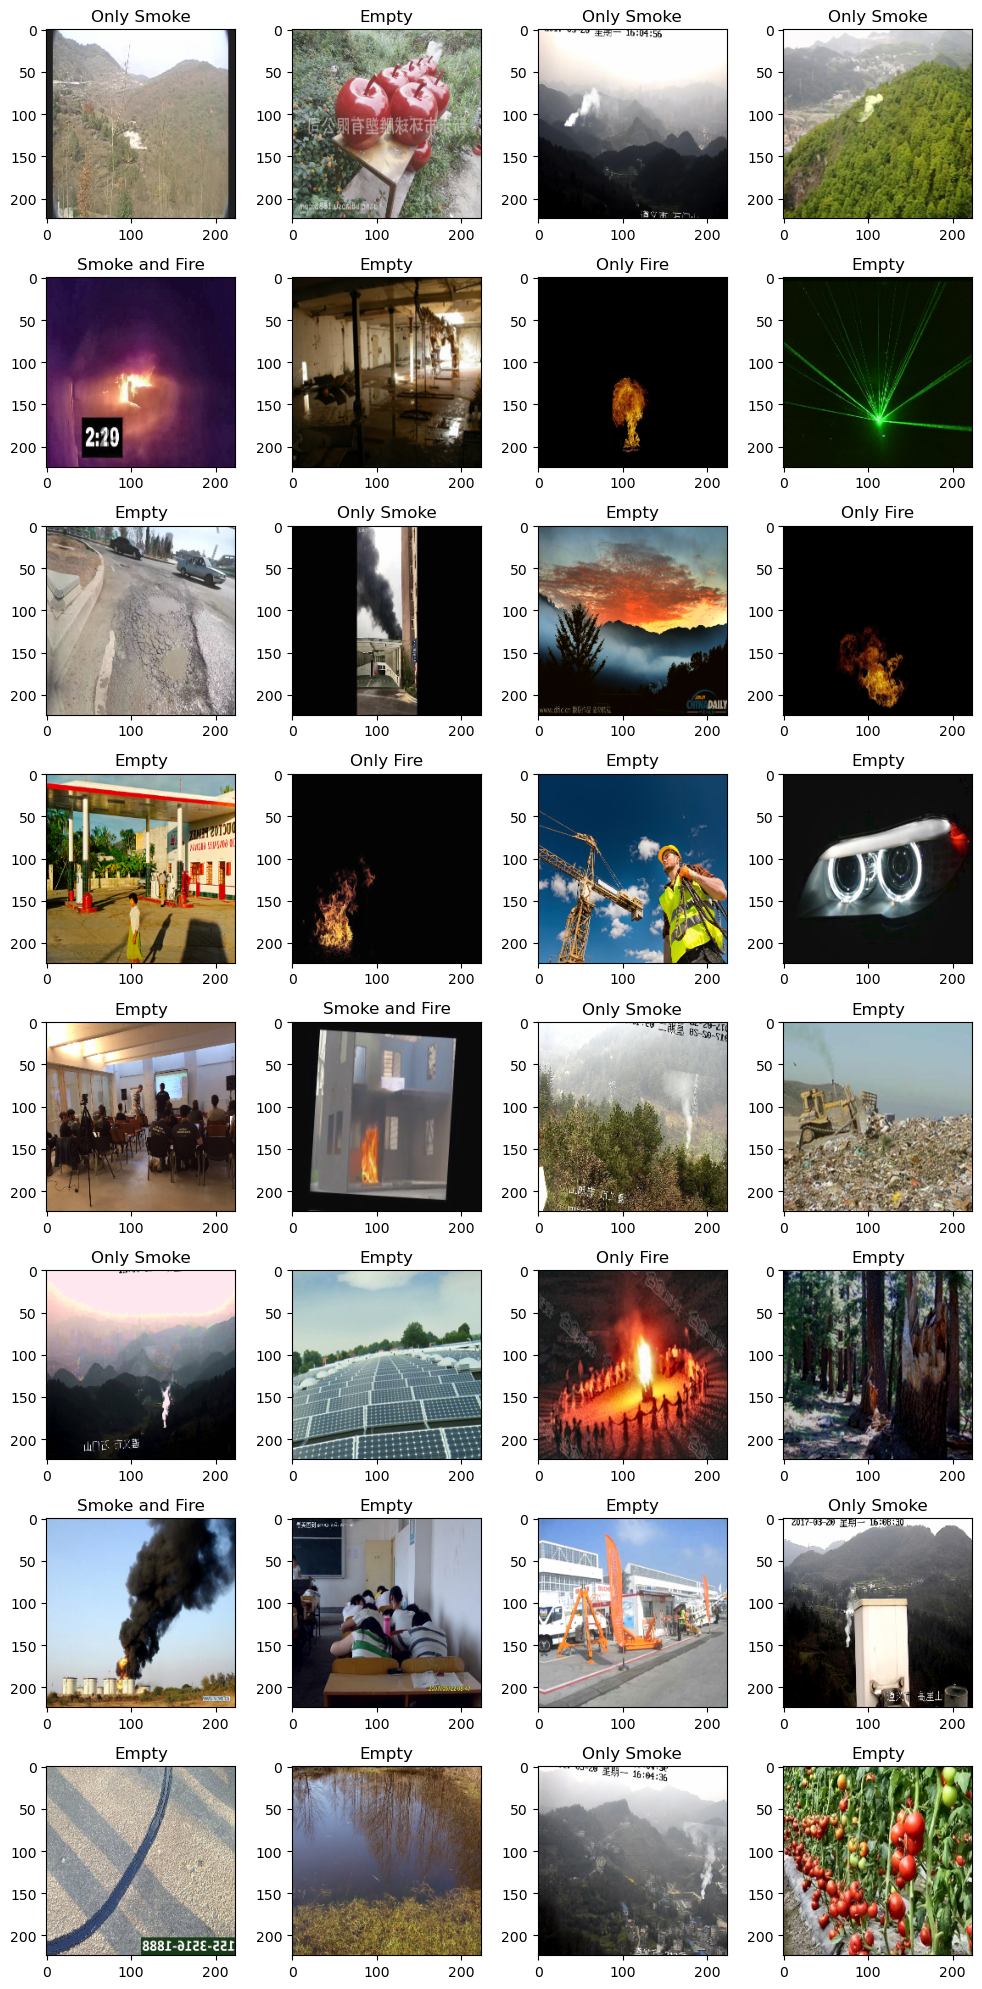

In [10]:
for i, (img, label) in enumerate(view_fasdd_cv_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Dataset Setup

## TRAIN

In [11]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.2),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

### DFire

In [12]:
# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dfire_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.TRAIN_IMG_DIR,
    label_dir = config.TRAIN_LABEL_DIR,
    num_classes=config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=train_transform)

print(f'\nTrain DFire dataset len: {len(train_dfire_dataset)}')
logger.info(f'\tTrain DFire dataset len: {len(train_dfire_dataset)}')


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763

Train DFire dataset len: 17221


### FASDD UAV

In [13]:
print("\nTRAIN FASDD UAV dataset")
logger.info("\nTRAIN FASDD UAV dataset")
train_fasdd_uav_ds = dataset_fasdd.FASDDDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    imgs_dir=config.FASDD_UAV_IMGS_DIR, 
    labels_file=config.FASDD_UAV_TRAIN_LABELS_FILE, 
    num_classes=config.N_CLASSES,
    ds_len=config.DS_LEN,
    transform=train_transform)

print(f'\nTrain FASDD UAV dataset len: {len(train_fasdd_uav_ds)}')
logger.info(f'\tTrain FASDD UAV dataset len: {len(train_fasdd_uav_ds)}')


TRAIN FASDD UAV dataset
DFire Removed wrong images: 0
DFire empty images: 5994
DFire only smoke images: 2541
DFire only fire images: 105
DFire smoke and fire images: 3911

Train FASDD UAV dataset len: 12551


### FASDD CV

In [14]:
print("\nTRAIN FASDD CV dataset")
logger.info("\nTRAIN FASDD CV dataset")
train_fasdd_cv_ds = dataset_fasdd.FASDDDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    imgs_dir=config.FASDD_CV_IMGS_DIR, 
    labels_file=config.FASDD_CV_TRAIN_LABELS_FILE, 
    num_classes=config.N_CLASSES,
    ds_len=config.DS_LEN,
    transform=train_transform)

print(f'\nTrain FASDD CV dataset len: {len(train_fasdd_cv_ds)}')
logger.info(f'\tTrain FASDD CV dataset len: {len(train_fasdd_cv_ds)}')


TRAIN FASDD CV dataset


DFire Removed wrong images: 0
DFire empty images: 19600
DFire only smoke images: 11708
DFire only fire images: 6276
DFire smoke and fire images: 10076

Train FASDD CV dataset len: 47660


## Concatenate Datasets

In [15]:
print("Concatenate Train DFire and FASDD UAV datasets")
logger.info("Concatenate Train DFire and FASDD UAV datasets")
train_ds_concat = torch.utils.data.ConcatDataset((train_dfire_dataset, train_fasdd_uav_ds))
print(f'Train dataset len: {len(train_ds_concat)}')
logger.info(f'Train dataset len: {len(train_ds_concat)}')

print("Concatenate with FASDD CV dataset")
logger.info("Concatenate with FASDD CV dataset")
train_ds = torch.utils.data.ConcatDataset((train_ds_concat, train_fasdd_cv_ds))
print(f'Train dataset len: {len(train_ds)}')
logger.info(f'Train dataset len: {len(train_ds)}')

Concatenate Train DFire and FASDD UAV datasets
Train dataset len: 29772
Concatenate with FASDD CV dataset
Train dataset len: 77432


## TRAIN Loader

In [16]:
train_loader = DataLoader(dataset=train_ds,
                          batch_size=config.BATCH_SIZE,
                          num_workers=config.NUM_WORKERS,
                          pin_memory=config.PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

## VALIDATION

In [17]:
# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(config.IMG_H, config.IMG_W, p=1),
    ToTensorV2(p=1),
    ]
)

### DFire

In [18]:
print("\nTEST DFire dataset")
logger.info("TEST DFire dataset")
val_dfire_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.VAL_IMG_DIR,
    label_dir = config.VAL_LABEL_DIR,
    num_classes = config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=val_transform)

print(f'\nTest dataset len: {len(val_dfire_dataset)}')
logger.info(f'\tTest dataset len: {len(val_dfire_dataset)}')


TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895

Test dataset len: 4306


### FASDD UAV

In [19]:
print("\nTEST FASDD UAV dataset")
logger.info("\nTEST FASDD UAV dataset")
val_fasdd_uav_ds = dataset_fasdd.FASDDDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    imgs_dir=config.FASDD_UAV_IMGS_DIR, 
    labels_file=config.FASDD_UAV_TEST_LABELS_FILE, 
    num_classes=config.N_CLASSES,
    ds_len=config.DS_LEN,
    transform=val_transform)

print(f'\nTest FASDD UAV dataset len: {len(val_fasdd_uav_ds)}')
logger.info(f'\tTest FASDD UAV dataset len: {len(val_fasdd_uav_ds)}')


TEST FASDD UAV dataset
DFire Removed wrong images: 0
DFire empty images: 1997
DFire only smoke images: 846
DFire only fire images: 35
DFire smoke and fire images: 1303

Test FASDD UAV dataset len: 4181


### FASDD CV

In [20]:
print("\nTEST FASDD CV dataset")
logger.info("\nTEST FASDD CV dataset")
val_fasdd_cv_ds = dataset_fasdd.FASDDDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    imgs_dir=config.FASDD_CV_IMGS_DIR, 
    labels_file=config.FASDD_CV_TEST_LABELS_FILE, 
    num_classes=config.N_CLASSES,
    ds_len=config.DS_LEN,
    transform=val_transform)

print(f'\nTest FASDD CV dataset len: {len(val_fasdd_cv_ds)}')
logger.info(f'\tTest FASDD CV dataset len: {len(val_fasdd_cv_ds)}')


TEST FASDD CV dataset
DFire Removed wrong images: 0
DFire empty images: 6533
DFire only smoke images: 3902
DFire only fire images: 2091
DFire smoke and fire images: 3358

Test FASDD CV dataset len: 15884


## Concatenate Datasets

In [21]:
print("Concatenate Test DFire and FASDD UAV datasets")
logger.info("Concatenate Test DFire and FASDD UAV datasets")
val_ds_concat = torch.utils.data.ConcatDataset((val_dfire_dataset, val_fasdd_uav_ds))
print(f'Test dataset len: {len(val_ds_concat)}')
logger.info(f'Test dataset len: {len(val_ds_concat)}')

print("Concatenate with FASDD CV dataset")
logger.info("Concatenate with FASDD CV dataset")
val_ds = torch.utils.data.ConcatDataset((val_ds_concat, val_fasdd_cv_ds))
print(f'Test dataset len: {len(val_ds)}')
logger.info(f'Test dataset len: {len(val_ds)}')

Concatenate Test DFire and FASDD UAV datasets
Test dataset len: 8487
Concatenate with FASDD CV dataset
Test dataset len: 24371


In [22]:
val_loader = DataLoader(dataset=val_ds,
                        batch_size=config.BATCH_SIZE,
                        num_workers=config.NUM_WORKERS,
                        pin_memory=config.PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)

# Model Setup

In [23]:
if config.MODEL == "BED":
    print("Using BED Classifier")
    logger.info("\nUsing BED Classifier")
    fp32_model = models.BED_CLASSIFIER(num_classes=config.N_CLASSES).to(config.DEVICE)   
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

optimizer = optim.Adam(fp32_model.parameters(), 
                       lr=config.LEARNING_RATE, 
                       weight_decay=config.WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=config.FACTOR, 
                                                 patience=config.PATIENCE, 
                                                 threshold=config.THRES, 
                                                 threshold_mode='abs',
                                                 min_lr=config.MIN_LR)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in fp32_model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(fp32_model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier

Trainable parameters = 93266
Total parameters = 93266



### Check Model Shape

In [24]:
in_rand_np = np.random.rand(4, 3, config.IMG_H, config.IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=config.DEVICE)
out_test = fp32_model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{fp32_model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{fp32_model}')

Model shape is tensor([[ 0.0321, -0.2658],
        [-0.0046, -0.1045],
        [ 0.1596, -0.1603],
        [ 0.0770, -0.1805]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (dropout1): Dropout2d(p=0.3, inplace=False)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (dropout2): Dropout2d(p=0.3, inplace=False)
    (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv31): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn31)

# Torchinfo: model summary

### FP32 Model

In [25]:
print(summary(fp32_model, input_size=(1, 3, config.IMG_H, config.IMG_W)))
logger.info(summary(fp32_model, input_size=(1, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                   Output Shape              Param #
BED_CLASSIFIER                           [1, 2]                    --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Conv2d: 2-1                       [1, 32, 224, 224]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 224, 224]         64
│    └─ReLU: 2-3                         [1, 32, 224, 224]         --
│    └─Dropout2d: 2-4                    [1, 32, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 32, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 16, 112, 112]         4,608
│    └─BatchNorm2d: 2-7                  [1, 16, 112, 112]         32
│    └─ReLU: 2-8                         [1, 16, 112, 112]         --
│    └─Dropout2d: 2-9                    [1, 16, 112, 112]         --
│    └─MaxPool2d: 2-10                   [1, 16, 56, 56]           --
│    └─Conv2d: 2-11                      [1, 16, 56, 56]           256
│    └─Bat

# Loss Function

In [26]:
if config.LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'\nLoss Function: BCE')
    print(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    logger.info(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    loss_fn = loss.BCE_LOSS(device=config.DEVICE, smoke_precision_weight=config.SMOKE_PRECISION_WEIGHT)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Loss Function: BCE
Smoke Precision Weight: 0.8


# Print and Log Config Values

In [27]:
''' ============================
    Print Config Values
============================ '''
print(f'\nDevice: {config.DEVICE}')
print(f'Learning Rate: {config.LEARNING_RATE}')
print(f'Weight Decay: {config.WEIGHT_DECAY}')
print(f'Scheduler factor: {config.FACTOR}')
print(f'Scheduler patience: {config.PATIENCE}')
print(f'Scheduler threshold: {config.THRES}')
print(f'Scheduler min learning rate: {config.MIN_LR}')
print(f'Batch Size: {config.BATCH_SIZE}')
print(f'IMG DIMS: ({config.IMG_H}, {config.IMG_W})')

logger.info(f'\nDevice: {config.DEVICE}')
logger.info(f'Learning Rate: {config.LEARNING_RATE}')
logger.info(f'Optimizer Weight Decay: {config.WEIGHT_DECAY}')
logger.info(f'Scheduler factor: {config.FACTOR}')
logger.info(f'Scheduler patience: {config.PATIENCE}')
logger.info(f'Scheduler threshold: {config.THRES}')
logger.info(f'Scheduler min learning rate: {config.MIN_LR}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')


Device: cuda
Learning Rate: 0.001
Weight Decay: 0.001
Scheduler factor: 0.8
Scheduler patience: 2
Scheduler threshold: 0.001
Scheduler min learning rate: 1e-06
Batch Size: 64
IMG DIMS: (224, 224)


# Loss and Metrics Loggers and Plotters

In [28]:
train_losses_logger = utils.LogLosses()
train_metrics_logger = utils.LogMetrics()
lr_logger = utils.LogLR(log_path=config.PLOTS_FOLDER)

val_losses_logger = utils.LogLosses()
val_metrics_logger = utils.LogMetrics()

loss_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Loss')
metrics_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Metric')

# Main Function

In [29]:
def train_loop(model, start_epoch=0):

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')
    
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = 0. #torch.tensor([0.])
    smoke_f1_min_save = 0.9 #torch.tensor([0.9])

    #start_epoch = 0
    epochs_plot = []
        
    for epoch in range(start_epoch, config.EPOCHS):

        print(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        
        #====================== TRAINING ========================#
        current_lr = train_epoch.get_lr(optimizer=optimizer)
        logger.info(f'Learning Rate = {current_lr:.6f}\n')
        lr_logger.log_lr(current_lr)
                
        train_losses, train_metrics = train_epoch.train_fn(
            loader=train_loader, 
            model=model, 
            optimizer=optimizer, 
            loss_fn=loss_fn,
            device=config.DEVICE)
        
        train_losses_logger.update_metrics(train_losses)
        train_metrics_logger.update_metrics(train_metrics)
                
        logger.info(utils.print_metrics_to_logger("TRAIN Stats", train_losses, train_metrics))
        
        #===================== VALIDATING =======================#
        with torch.no_grad():
            val_losses, val_metrics = val_epoch.eval_fn(
                loader=val_loader, 
                model=model,                         
                loss_fn=loss_fn,
                device=config.DEVICE)
            
            scheduler.step(val_losses['Total'])
            
            val_losses_logger.update_metrics(val_losses)
            val_metrics_logger.update_metrics(val_metrics)

            logger.info(utils.print_metrics_to_logger("VAL Stats", val_losses, val_metrics))
            
        epochs_plot.append(epoch)

        loss_plotter.plot_all_metrics(
            train_losses_logger.get_metrics(),
            val_losses_logger.get_metrics(),
            epochs_plot)

        metrics_plotter.plot_all_metrics(
            train_metrics_logger.get_metrics(),
            val_metrics_logger.get_metrics(),
            epochs_plot)

        lr_logger.plot_lr(epochs_plot)
        
        #======================= SAVING =========================#
        if ( (epoch+1) % 5 ) == 0:
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__5epoch.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
            
        if best_valid_loss > val_losses['Total']:
            best_valid_loss = val_losses['Total']
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"Saving model with new best validation loss: {best_valid_loss:.3f}")
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + 'best_loss'  + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < val_metrics['Precision'][0] ) and ( val_metrics['F1'][0] > smoke_f1_min_save ) :
            best_smoke_precision = val_metrics['Precision'][0]
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"Saving model with new best smoke precision: {best_smoke_precision:.3f}")
            save_precision_name = f'best_smoke__precision={np.round(best_smoke_precision, decimals=4)}__epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_precision_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
            
        # Save model if precision > 0.9 and recall > 0.9
        if ( val_metrics['Precision'][0] > 0.9 ) and ( val_metrics['Recall'][0] > 0.9 ) :
            print("\nSaving model with precision > 0.9 and recall > 0.9")
            logger.info("Saving model with precision > 0.9 and recall > 0.9")
            save_pre_name = f'smoke__precision={np.round(val_metrics["Precision"][0], decimals=4)}__' 
            save_rec_name = f'recall={np.round(val_metrics["Recall"][0], decimals=4)}__'
            save_pre_rec_name = save_pre_name + save_rec_name + f'epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_pre_rec_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), config.WEIGHTS_FOLDER + 'last_' + config.MODEL + '_classifier.pt') 
    
    #======================= FINISH =========================#
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [30]:
if __name__ == "__main__":
       
    trained_model = train_loop(model=fp32_model)


***Start Training: 19:44:03


=== EPOCH 0/99 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  6.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.239      |31.977      |28.263      



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.705      |28.735      |22.970      
SMOKE -> Precision: 0.735 - Recall: 0.751 - Accuracy: 0.755 - F1: 0.743
FIRE -> Precision: 0.757 - Recall: 0.850 - Accuracy: 0.863 - F1: 0.801

Saving model with new best validation loss: 51.705

=== EPOCH 1/99 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.773      |25.716      |19.057      



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.769      |25.055      |20.715      
SMOKE -> Precision: 0.792 - Recall: 0.746 - Accuracy: 0.788 - F1: 0.768
FIRE -> Precision: 0.749 - Recall: 0.922 - Accuracy: 0.875 - F1: 0.827

Saving model with new best validation loss: 45.769

=== EPOCH 2/99 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  6.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.970      |23.780      |16.190      



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.757      |22.382      |14.375      
SMOKE -> Precision: 0.849 - Recall: 0.718 - Accuracy: 0.807 - F1: 0.778
FIRE -> Precision: 0.838 - Recall: 0.919 - Accuracy: 0.916 - F1: 0.876

Saving model with new best validation loss: 36.757

=== EPOCH 3/99 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.581      |22.809      |14.773      



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.716      |22.829      |11.887      
SMOKE -> Precision: 0.860 - Recall: 0.705 - Accuracy: 0.806 - F1: 0.774
FIRE -> Precision: 0.876 - Recall: 0.909 - Accuracy: 0.929 - F1: 0.892

Saving model with new best validation loss: 34.716

=== EPOCH 4/99 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.748      |21.917      |13.831      



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.511      |22.235      |13.277      
SMOKE -> Precision: 0.839 - Recall: 0.748 - Accuracy: 0.814 - F1: 0.791
FIRE -> Precision: 0.830 - Recall: 0.927 - Accuracy: 0.915 - F1: 0.876

=== EPOCH 5/99 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:51<00:00,  7.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.492      |21.207      |13.284      



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.271      |21.051      |11.220      
SMOKE -> Precision: 0.888 - Recall: 0.709 - Accuracy: 0.821 - F1: 0.789
FIRE -> Precision: 0.881 - Recall: 0.909 - Accuracy: 0.931 - F1: 0.895

Saving model with new best validation loss: 32.271

=== EPOCH 6/99 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:51<00:00,  7.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.594      |20.850      |12.745      



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.898      |22.166      |17.732      
SMOKE -> Precision: 0.806 - Recall: 0.796 - Accuracy: 0.813 - F1: 0.801
FIRE -> Precision: 0.746 - Recall: 0.976 - Accuracy: 0.884 - F1: 0.846

=== EPOCH 7/99 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.574      |20.296      |12.278      



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.258      |19.595      |9.663       
SMOKE -> Precision: 0.881 - Recall: 0.761 - Accuracy: 0.839 - F1: 0.817
FIRE -> Precision: 0.922 - Recall: 0.895 - Accuracy: 0.942 - F1: 0.909

Saving model with new best validation loss: 29.258

=== EPOCH 8/99 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.744      |19.843      |11.901      



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.969      |19.929      |10.040      
SMOKE -> Precision: 0.868 - Recall: 0.788 - Accuracy: 0.844 - F1: 0.826
FIRE -> Precision: 0.889 - Recall: 0.920 - Accuracy: 0.937 - F1: 0.904

=== EPOCH 9/99 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  6.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.264      |19.592      |11.672      



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.413      |20.299      |10.113      
SMOKE -> Precision: 0.913 - Recall: 0.715 - Accuracy: 0.834 - F1: 0.802
FIRE -> Precision: 0.879 - Recall: 0.939 - Accuracy: 0.938 - F1: 0.908

=== EPOCH 10/99 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.833      |19.227      |11.605      



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.034      |20.515      |11.519      
SMOKE -> Precision: 0.851 - Recall: 0.811 - Accuracy: 0.844 - F1: 0.831
FIRE -> Precision: 0.861 - Recall: 0.928 - Accuracy: 0.928 - F1: 0.894

=== EPOCH 11/99 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.445      |18.548      |10.897      



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.813      |18.829      |9.984       
SMOKE -> Precision: 0.898 - Recall: 0.764 - Accuracy: 0.848 - F1: 0.826
FIRE -> Precision: 0.866 - Recall: 0.954 - Accuracy: 0.937 - F1: 0.908

Saving model with new best validation loss: 28.813

=== EPOCH 12/99 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.818      |18.260      |10.558      



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.197      |18.714      |9.483       
SMOKE -> Precision: 0.866 - Recall: 0.795 - Accuracy: 0.845 - F1: 0.829
FIRE -> Precision: 0.894 - Recall: 0.934 - Accuracy: 0.943 - F1: 0.913

Saving model with new best validation loss: 28.197

=== EPOCH 13/99 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.469      |17.960      |10.509      



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.467      |19.287      |10.181      
SMOKE -> Precision: 0.833 - Recall: 0.848 - Accuracy: 0.848 - F1: 0.841
FIRE -> Precision: 0.861 - Recall: 0.954 - Accuracy: 0.935 - F1: 0.905

=== EPOCH 14/99 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.120      |17.673      |10.446      



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.859      |18.355      |8.504       
SMOKE -> Precision: 0.892 - Recall: 0.776 - Accuracy: 0.850 - F1: 0.830
FIRE -> Precision: 0.908 - Recall: 0.931 - Accuracy: 0.947 - F1: 0.919

Saving model with new best validation loss: 26.859

=== EPOCH 15/99 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:51<00:00,  7.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.740      |17.470      |10.270      



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.634      |17.779      |9.855       
SMOKE -> Precision: 0.884 - Recall: 0.823 - Accuracy: 0.866 - F1: 0.852
FIRE -> Precision: 0.871 - Recall: 0.952 - Accuracy: 0.939 - F1: 0.910

=== EPOCH 16/99 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.332      |17.323      |10.009      



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.486      |18.171      |9.315       
SMOKE -> Precision: 0.920 - Recall: 0.739 - Accuracy: 0.847 - F1: 0.820
FIRE -> Precision: 0.892 - Recall: 0.942 - Accuracy: 0.944 - F1: 0.917

=== EPOCH 17/99 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:51<00:00,  7.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.315      |17.314      |10.001      



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.076      |17.187      |8.889       
SMOKE -> Precision: 0.880 - Recall: 0.828 - Accuracy: 0.866 - F1: 0.853
FIRE -> Precision: 0.894 - Recall: 0.942 - Accuracy: 0.945 - F1: 0.917

Saving model with new best validation loss: 26.076

=== EPOCH 18/99 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.749      |16.933      |9.816       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.000      |17.042      |6.958       
SMOKE -> Precision: 0.908 - Recall: 0.806 - Accuracy: 0.870 - F1: 0.854
FIRE -> Precision: 0.951 - Recall: 0.920 - Accuracy: 0.959 - F1: 0.935

Saving model with new best validation loss: 24.000

=== EPOCH 19/99 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.319      |16.763      |9.556       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.319      |17.158      |8.161       
SMOKE -> Precision: 0.919 - Recall: 0.773 - Accuracy: 0.861 - F1: 0.840
FIRE -> Precision: 0.902 - Recall: 0.950 - Accuracy: 0.950 - F1: 0.925

=== EPOCH 20/99 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  6.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.195      |16.488      |9.708       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.189      |17.251      |8.938       
SMOKE -> Precision: 0.889 - Recall: 0.812 - Accuracy: 0.864 - F1: 0.849
FIRE -> Precision: 0.882 - Recall: 0.966 - Accuracy: 0.947 - F1: 0.922

=== EPOCH 21/99 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:51<00:00,  7.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.839      |16.308      |9.531       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.478      |18.762      |9.716       
SMOKE -> Precision: 0.868 - Recall: 0.829 - Accuracy: 0.860 - F1: 0.848
FIRE -> Precision: 0.869 - Recall: 0.963 - Accuracy: 0.941 - F1: 0.914

=== EPOCH 22/99 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:51<00:00,  7.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.855      |15.666      |9.189       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.559      |17.839      |8.720       
SMOKE -> Precision: 0.925 - Recall: 0.784 - Accuracy: 0.868 - F1: 0.849
FIRE -> Precision: 0.880 - Recall: 0.973 - Accuracy: 0.948 - F1: 0.924

=== EPOCH 23/99 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:54<00:00,  6.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.733      |15.629      |9.104       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.992      |17.651      |9.341       
SMOKE -> Precision: 0.863 - Recall: 0.853 - Accuracy: 0.867 - F1: 0.858
FIRE -> Precision: 0.880 - Recall: 0.957 - Accuracy: 0.944 - F1: 0.917

=== EPOCH 24/99 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:51<00:00,  7.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.412      |15.350      |9.062       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.463      |17.506      |8.957       
SMOKE -> Precision: 0.886 - Recall: 0.831 - Accuracy: 0.870 - F1: 0.858
FIRE -> Precision: 0.890 - Recall: 0.955 - Accuracy: 0.947 - F1: 0.921

=== EPOCH 25/99 ===
Learning Rate = 0.0005120000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.732      |15.039      |8.693       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.910      |16.835      |9.075       
SMOKE -> Precision: 0.913 - Recall: 0.825 - Accuracy: 0.880 - F1: 0.867
FIRE -> Precision: 0.882 - Recall: 0.961 - Accuracy: 0.946 - F1: 0.920

=== EPOCH 26/99 ===
Learning Rate = 0.0005120000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.377      |14.757      |8.620       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.722      |15.746      |8.976       
SMOKE -> Precision: 0.915 - Recall: 0.834 - Accuracy: 0.885 - F1: 0.873
FIRE -> Precision: 0.880 - Recall: 0.975 - Accuracy: 0.949 - F1: 0.925

=== EPOCH 27/99 ===
Learning Rate = 0.0005120000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.237      |14.672      |8.565       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.154      |18.745      |9.409       
SMOKE -> Precision: 0.849 - Recall: 0.883 - Accuracy: 0.871 - F1: 0.865
FIRE -> Precision: 0.874 - Recall: 0.966 - Accuracy: 0.944 - F1: 0.917

=== EPOCH 28/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.615      |14.284      |8.331       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.084      |16.693      |9.390       
SMOKE -> Precision: 0.905 - Recall: 0.851 - Accuracy: 0.888 - F1: 0.877
FIRE -> Precision: 0.865 - Recall: 0.975 - Accuracy: 0.943 - F1: 0.917

=== EPOCH 29/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.194      |14.056      |8.138       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.874      |15.930      |7.943       
SMOKE -> Precision: 0.936 - Recall: 0.788 - Accuracy: 0.874 - F1: 0.855
FIRE -> Precision: 0.892 - Recall: 0.972 - Accuracy: 0.953 - F1: 0.930

Saving model with new best validation loss: 23.874

=== EPOCH 30/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.237      |13.943      |8.293       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.783      |14.877      |6.906       
SMOKE -> Precision: 0.930 - Recall: 0.819 - Accuracy: 0.886 - F1: 0.871
FIRE -> Precision: 0.913 - Recall: 0.964 - Accuracy: 0.959 - F1: 0.938

Saving model with new best validation loss: 21.783

=== EPOCH 31/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.094      |13.953      |8.141       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.454      |16.241      |9.214       
SMOKE -> Precision: 0.890 - Recall: 0.866 - Accuracy: 0.887 - F1: 0.878
FIRE -> Precision: 0.867 - Recall: 0.975 - Accuracy: 0.943 - F1: 0.918

=== EPOCH 32/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.899      |13.893      |8.006       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.214      |15.895      |9.320       
SMOKE -> Precision: 0.899 - Recall: 0.839 - Accuracy: 0.880 - F1: 0.868
FIRE -> Precision: 0.858 - Recall: 0.981 - Accuracy: 0.941 - F1: 0.916

=== EPOCH 33/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.834      |13.790      |8.043       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.513      |15.292      |7.221       
SMOKE -> Precision: 0.915 - Recall: 0.827 - Accuracy: 0.882 - F1: 0.869
FIRE -> Precision: 0.914 - Recall: 0.957 - Accuracy: 0.957 - F1: 0.935

=== EPOCH 34/99 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.165      |13.330      |7.835       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.221      |14.767      |9.454       
SMOKE -> Precision: 0.904 - Recall: 0.880 - Accuracy: 0.899 - F1: 0.892
FIRE -> Precision: 0.865 - Recall: 0.974 - Accuracy: 0.942 - F1: 0.916

=== EPOCH 35/99 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.947      |13.235      |7.713       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.556      |14.082      |8.474       
SMOKE -> Precision: 0.922 - Recall: 0.843 - Accuracy: 0.892 - F1: 0.881
FIRE -> Precision: 0.882 - Recall: 0.980 - Accuracy: 0.951 - F1: 0.928

=== EPOCH 36/99 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:54<00:00,  6.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.173      |13.366      |7.806       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.689      |14.626      |7.063       
SMOKE -> Precision: 0.918 - Recall: 0.852 - Accuracy: 0.895 - F1: 0.884
FIRE -> Precision: 0.914 - Recall: 0.964 - Accuracy: 0.959 - F1: 0.939

Saving model with new best validation loss: 21.689

=== EPOCH 37/99 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.881      |13.147      |7.734       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.383      |14.400      |8.982       
SMOKE -> Precision: 0.920 - Recall: 0.857 - Accuracy: 0.898 - F1: 0.887
FIRE -> Precision: 0.871 - Recall: 0.979 - Accuracy: 0.946 - F1: 0.922

=== EPOCH 38/99 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.749      |13.033      |7.716       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.631      |14.110      |7.522       
SMOKE -> Precision: 0.916 - Recall: 0.854 - Accuracy: 0.894 - F1: 0.884
FIRE -> Precision: 0.899 - Recall: 0.976 - Accuracy: 0.957 - F1: 0.936

Saving model with new best validation loss: 21.631

=== EPOCH 39/99 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.880      |13.109      |7.771       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.913      |14.570      |7.343       
SMOKE -> Precision: 0.922 - Recall: 0.818 - Accuracy: 0.882 - F1: 0.867
FIRE -> Precision: 0.904 - Recall: 0.972 - Accuracy: 0.958 - F1: 0.937

=== EPOCH 40/99 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.565      |12.933      |7.632       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.649      |14.468      |7.182       
SMOKE -> Precision: 0.917 - Recall: 0.862 - Accuracy: 0.898 - F1: 0.889
FIRE -> Precision: 0.913 - Recall: 0.962 - Accuracy: 0.958 - F1: 0.937

=== EPOCH 41/99 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.553      |12.954      |7.598       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.882      |15.522      |8.359       
SMOKE -> Precision: 0.898 - Recall: 0.875 - Accuracy: 0.894 - F1: 0.887
FIRE -> Precision: 0.890 - Recall: 0.968 - Accuracy: 0.951 - F1: 0.927

=== EPOCH 42/99 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:54<00:00,  6.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.059      |12.659      |7.400       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.037      |13.771      |7.266       
SMOKE -> Precision: 0.918 - Recall: 0.877 - Accuracy: 0.905 - F1: 0.897
FIRE -> Precision: 0.915 - Recall: 0.962 - Accuracy: 0.959 - F1: 0.938

Saving model with new best validation loss: 21.037

=== EPOCH 43/99 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:54<00:00,  6.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.902      |12.518      |7.384       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.998      |14.059      |7.939       
SMOKE -> Precision: 0.928 - Recall: 0.838 - Accuracy: 0.893 - F1: 0.881
FIRE -> Precision: 0.900 - Recall: 0.968 - Accuracy: 0.955 - F1: 0.932

=== EPOCH 44/99 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.635      |12.358      |7.277       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.487      |13.731      |6.757       
SMOKE -> Precision: 0.933 - Recall: 0.832 - Accuracy: 0.893 - F1: 0.880
FIRE -> Precision: 0.931 - Recall: 0.950 - Accuracy: 0.961 - F1: 0.940

Saving model with new best validation loss: 20.487

=== EPOCH 45/99 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.796      |12.379      |7.417       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.836      |14.224      |7.613       
SMOKE -> Precision: 0.912 - Recall: 0.872 - Accuracy: 0.900 - F1: 0.891
FIRE -> Precision: 0.902 - Recall: 0.965 - Accuracy: 0.955 - F1: 0.932

=== EPOCH 46/99 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.592      |12.279      |7.314       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.524      |14.444      |9.080       
SMOKE -> Precision: 0.919 - Recall: 0.867 - Accuracy: 0.901 - F1: 0.892
FIRE -> Precision: 0.875 - Recall: 0.973 - Accuracy: 0.946 - F1: 0.921

=== EPOCH 47/99 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.624      |12.347      |7.277       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.795      |14.726      |7.069       
SMOKE -> Precision: 0.935 - Recall: 0.817 - Accuracy: 0.887 - F1: 0.872
FIRE -> Precision: 0.902 - Recall: 0.977 - Accuracy: 0.958 - F1: 0.938

=== EPOCH 48/99 ===
Learning Rate = 0.00020971520000000012



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  6.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.105      |12.023      |7.082       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.730      |14.579      |8.151       
SMOKE -> Precision: 0.919 - Recall: 0.839 - Accuracy: 0.889 - F1: 0.877
FIRE -> Precision: 0.890 - Recall: 0.971 - Accuracy: 0.952 - F1: 0.929

=== EPOCH 49/99 ===
Learning Rate = 0.00020971520000000012



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.781      |11.893      |6.888       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.053      |14.424      |8.629       
SMOKE -> Precision: 0.921 - Recall: 0.846 - Accuracy: 0.893 - F1: 0.882
FIRE -> Precision: 0.873 - Recall: 0.982 - Accuracy: 0.948 - F1: 0.924

=== EPOCH 50/99 ===
Learning Rate = 0.00020971520000000012



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.850      |11.960      |6.890       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.953      |14.818      |9.135       
SMOKE -> Precision: 0.897 - Recall: 0.890 - Accuracy: 0.900 - F1: 0.893
FIRE -> Precision: 0.872 - Recall: 0.983 - Accuracy: 0.948 - F1: 0.924

=== EPOCH 51/99 ===
Learning Rate = 0.0001677721600000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:51<00:00,  7.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.515      |11.706      |6.809       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.942      |13.668      |7.274       
SMOKE -> Precision: 0.915 - Recall: 0.874 - Accuracy: 0.902 - F1: 0.894
FIRE -> Precision: 0.901 - Recall: 0.972 - Accuracy: 0.956 - F1: 0.935

=== EPOCH 52/99 ===
Learning Rate = 0.0001677721600000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.436      |11.642      |6.794       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.417      |14.729      |6.688       
SMOKE -> Precision: 0.909 - Recall: 0.870 - Accuracy: 0.898 - F1: 0.889
FIRE -> Precision: 0.919 - Recall: 0.967 - Accuracy: 0.962 - F1: 0.942

=== EPOCH 53/99 ===
Learning Rate = 0.0001677721600000001



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.470      |11.560      |6.909       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.656      |13.419      |7.237       
SMOKE -> Precision: 0.934 - Recall: 0.849 - Accuracy: 0.900 - F1: 0.889
FIRE -> Precision: 0.911 - Recall: 0.965 - Accuracy: 0.958 - F1: 0.938

=== EPOCH 54/99 ===
Learning Rate = 0.00013421772800000008



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.165      |11.347      |6.817       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.680      |13.635      |7.046       
SMOKE -> Precision: 0.921 - Recall: 0.859 - Accuracy: 0.899 - F1: 0.889
FIRE -> Precision: 0.909 - Recall: 0.972 - Accuracy: 0.959 - F1: 0.939

=== EPOCH 55/99 ===
Learning Rate = 0.00013421772800000008



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:51<00:00,  7.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.108      |11.419      |6.689       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.095      |13.437      |7.659       
SMOKE -> Precision: 0.922 - Recall: 0.875 - Accuracy: 0.906 - F1: 0.898
FIRE -> Precision: 0.892 - Recall: 0.981 - Accuracy: 0.955 - F1: 0.934

=== EPOCH 56/99 ===
Learning Rate = 0.00013421772800000008



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.875      |11.252      |6.623       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.028      |13.141      |6.887       
SMOKE -> Precision: 0.932 - Recall: 0.878 - Accuracy: 0.912 - F1: 0.904
FIRE -> Precision: 0.912 - Recall: 0.971 - Accuracy: 0.960 - F1: 0.941

Saving model with new best validation loss: 20.028

Saving model with new best smoke precision: 0.932

=== EPOCH 57/99 ===
Learning Rate = 0.00013421772800000008



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.580      |11.144      |6.436       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.489      |13.583      |6.906       
SMOKE -> Precision: 0.920 - Recall: 0.871 - Accuracy: 0.903 - F1: 0.895
FIRE -> Precision: 0.914 - Recall: 0.972 - Accuracy: 0.961 - F1: 0.942

=== EPOCH 58/99 ===
Learning Rate = 0.00013421772800000008



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.652      |11.073      |6.580       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.367      |13.347      |8.019       
SMOKE -> Precision: 0.919 - Recall: 0.862 - Accuracy: 0.899 - F1: 0.890
FIRE -> Precision: 0.886 - Recall: 0.979 - Accuracy: 0.953 - F1: 0.931

=== EPOCH 59/99 ===
Learning Rate = 0.00013421772800000008



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.678      |11.081      |6.596       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.681      |13.173      |8.508       
SMOKE -> Precision: 0.940 - Recall: 0.850 - Accuracy: 0.903 - F1: 0.892
FIRE -> Precision: 0.885 - Recall: 0.977 - Accuracy: 0.951 - F1: 0.929

=== EPOCH 60/99 ===
Learning Rate = 0.00010737418240000007



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.542      |11.041      |6.501       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.750      |13.480      |7.270       
SMOKE -> Precision: 0.932 - Recall: 0.860 - Accuracy: 0.904 - F1: 0.895
FIRE -> Precision: 0.906 - Recall: 0.969 - Accuracy: 0.957 - F1: 0.937

=== EPOCH 61/99 ===
Learning Rate = 0.00010737418240000007



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.327      |10.902      |6.425       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.097      |13.376      |6.720       
SMOKE -> Precision: 0.922 - Recall: 0.870 - Accuracy: 0.904 - F1: 0.895
FIRE -> Precision: 0.917 - Recall: 0.970 - Accuracy: 0.962 - F1: 0.942

=== EPOCH 62/99 ===
Learning Rate = 0.00010737418240000007



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.367      |10.947      |6.421       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.019      |14.100      |7.920       
SMOKE -> Precision: 0.911 - Recall: 0.879 - Accuracy: 0.903 - F1: 0.895
FIRE -> Precision: 0.891 - Recall: 0.978 - Accuracy: 0.954 - F1: 0.933

=== EPOCH 63/99 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:54<00:00,  6.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.219      |10.836      |6.383       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.817      |13.669      |7.148       
SMOKE -> Precision: 0.917 - Recall: 0.880 - Accuracy: 0.906 - F1: 0.898
FIRE -> Precision: 0.906 - Recall: 0.975 - Accuracy: 0.959 - F1: 0.939

=== EPOCH 64/99 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.147      |10.813      |6.334       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.970      |13.004      |6.965       
SMOKE -> Precision: 0.924 - Recall: 0.872 - Accuracy: 0.906 - F1: 0.897
FIRE -> Precision: 0.911 - Recall: 0.973 - Accuracy: 0.960 - F1: 0.941

Saving model with new best validation loss: 19.970

=== EPOCH 65/99 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.839      |10.526      |6.313       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.880      |13.164      |7.716       
SMOKE -> Precision: 0.927 - Recall: 0.872 - Accuracy: 0.907 - F1: 0.898
FIRE -> Precision: 0.902 - Recall: 0.972 - Accuracy: 0.957 - F1: 0.936

=== EPOCH 66/99 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:51<00:00,  7.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.043      |10.651      |6.393       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.756      |13.276      |7.480       
SMOKE -> Precision: 0.927 - Recall: 0.858 - Accuracy: 0.901 - F1: 0.891
FIRE -> Precision: 0.897 - Recall: 0.976 - Accuracy: 0.956 - F1: 0.935

=== EPOCH 67/99 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.070      |10.677      |6.393       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.816      |13.978      |7.838       
SMOKE -> Precision: 0.908 - Recall: 0.878 - Accuracy: 0.900 - F1: 0.893
FIRE -> Precision: 0.893 - Recall: 0.979 - Accuracy: 0.955 - F1: 0.934

=== EPOCH 68/99 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.761      |10.612      |6.150       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.076      |12.653      |6.424       
SMOKE -> Precision: 0.925 - Recall: 0.871 - Accuracy: 0.906 - F1: 0.897
FIRE -> Precision: 0.924 - Recall: 0.962 - Accuracy: 0.962 - F1: 0.942

Saving model with new best validation loss: 19.076

=== EPOCH 69/99 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  6.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.722      |10.521      |6.201       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.022      |12.986      |7.036       
SMOKE -> Precision: 0.927 - Recall: 0.866 - Accuracy: 0.905 - F1: 0.895
FIRE -> Precision: 0.908 - Recall: 0.975 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 70/99 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.617      |10.422      |6.195       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.412      |13.719      |7.693       
SMOKE -> Precision: 0.914 - Recall: 0.871 - Accuracy: 0.901 - F1: 0.892
FIRE -> Precision: 0.898 - Recall: 0.976 - Accuracy: 0.956 - F1: 0.935

=== EPOCH 71/99 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.775      |10.484      |6.291       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.299      |13.107      |7.192       
SMOKE -> Precision: 0.926 - Recall: 0.872 - Accuracy: 0.907 - F1: 0.898
FIRE -> Precision: 0.901 - Recall: 0.979 - Accuracy: 0.959 - F1: 0.939

=== EPOCH 72/99 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.668      |10.488      |6.179       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.441      |12.840      |7.601       
SMOKE -> Precision: 0.928 - Recall: 0.878 - Accuracy: 0.910 - F1: 0.902
FIRE -> Precision: 0.895 - Recall: 0.980 - Accuracy: 0.956 - F1: 0.935

=== EPOCH 73/99 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:51<00:00,  7.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.559      |10.359      |6.200       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.093      |12.867      |7.225       
SMOKE -> Precision: 0.933 - Recall: 0.862 - Accuracy: 0.906 - F1: 0.896
FIRE -> Precision: 0.904 - Recall: 0.976 - Accuracy: 0.959 - F1: 0.939

=== EPOCH 74/99 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.372      |10.284      |6.088       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.764      |13.486      |7.278       
SMOKE -> Precision: 0.929 - Recall: 0.860 - Accuracy: 0.903 - F1: 0.893
FIRE -> Precision: 0.906 - Recall: 0.971 - Accuracy: 0.958 - F1: 0.937

=== EPOCH 75/99 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.368      |10.188      |6.180       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.755      |12.814      |6.941       
SMOKE -> Precision: 0.937 - Recall: 0.863 - Accuracy: 0.908 - F1: 0.899
FIRE -> Precision: 0.911 - Recall: 0.976 - Accuracy: 0.961 - F1: 0.942

=== EPOCH 76/99 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.297      |10.189      |6.107       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.441      |13.257      |7.184       
SMOKE -> Precision: 0.913 - Recall: 0.899 - Accuracy: 0.912 - F1: 0.906
FIRE -> Precision: 0.907 - Recall: 0.973 - Accuracy: 0.959 - F1: 0.939

=== EPOCH 77/99 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.167      |10.088      |6.079       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.568      |12.805      |6.763       
SMOKE -> Precision: 0.925 - Recall: 0.880 - Accuracy: 0.910 - F1: 0.902
FIRE -> Precision: 0.917 - Recall: 0.970 - Accuracy: 0.962 - F1: 0.943

=== EPOCH 78/99 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  6.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.221      |10.125      |6.096       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.811      |12.799      |7.012       
SMOKE -> Precision: 0.934 - Recall: 0.873 - Accuracy: 0.911 - F1: 0.903
FIRE -> Precision: 0.909 - Recall: 0.976 - Accuracy: 0.960 - F1: 0.941

Saving model with new best smoke precision: 0.934

=== EPOCH 79/99 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.068      |10.074      |5.994       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.671      |13.076      |7.596       
SMOKE -> Precision: 0.917 - Recall: 0.881 - Accuracy: 0.906 - F1: 0.898
FIRE -> Precision: 0.899 - Recall: 0.978 - Accuracy: 0.957 - F1: 0.937

=== EPOCH 80/99 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:51<00:00,  7.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.107      |10.065      |6.043       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.374      |12.605      |6.769       
SMOKE -> Precision: 0.927 - Recall: 0.879 - Accuracy: 0.910 - F1: 0.902
FIRE -> Precision: 0.911 - Recall: 0.973 - Accuracy: 0.960 - F1: 0.941

=== EPOCH 81/99 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.140      |10.138      |6.002       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.567      |12.909      |7.659       
SMOKE -> Precision: 0.925 - Recall: 0.878 - Accuracy: 0.909 - F1: 0.901
FIRE -> Precision: 0.897 - Recall: 0.978 - Accuracy: 0.956 - F1: 0.936

=== EPOCH 82/99 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.864      |9.970       |5.894       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.820      |12.652      |7.169       
SMOKE -> Precision: 0.930 - Recall: 0.878 - Accuracy: 0.911 - F1: 0.903
FIRE -> Precision: 0.906 - Recall: 0.977 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 83/99 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.052      |10.106      |5.946       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.056      |12.963      |7.093       
SMOKE -> Precision: 0.916 - Recall: 0.889 - Accuracy: 0.909 - F1: 0.902
FIRE -> Precision: 0.909 - Recall: 0.973 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 84/99 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.875      |10.029      |5.847       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.051      |12.450      |6.601       
SMOKE -> Precision: 0.930 - Recall: 0.889 - Accuracy: 0.916 - F1: 0.909
FIRE -> Precision: 0.916 - Recall: 0.972 - Accuracy: 0.962 - F1: 0.943

Saving model with new best validation loss: 19.051

=== EPOCH 85/99 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.891      |9.962       |5.929       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.971      |12.351      |6.620       
SMOKE -> Precision: 0.929 - Recall: 0.889 - Accuracy: 0.916 - F1: 0.908
FIRE -> Precision: 0.918 - Recall: 0.972 - Accuracy: 0.963 - F1: 0.944

Saving model with new best validation loss: 18.971

=== EPOCH 86/99 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:55<00:00,  6.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.940      |9.987       |5.954       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.618      |12.793      |7.825       
SMOKE -> Precision: 0.927 - Recall: 0.884 - Accuracy: 0.913 - F1: 0.905
FIRE -> Precision: 0.898 - Recall: 0.977 - Accuracy: 0.956 - F1: 0.935

=== EPOCH 87/99 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.891      |9.945       |5.946       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.195      |12.298      |6.897       
SMOKE -> Precision: 0.935 - Recall: 0.878 - Accuracy: 0.914 - F1: 0.906
FIRE -> Precision: 0.913 - Recall: 0.974 - Accuracy: 0.961 - F1: 0.942

Saving model with new best smoke precision: 0.935

=== EPOCH 88/99 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.967      |10.033      |5.934       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.201      |12.496      |6.706       
SMOKE -> Precision: 0.932 - Recall: 0.881 - Accuracy: 0.914 - F1: 0.906
FIRE -> Precision: 0.914 - Recall: 0.971 - Accuracy: 0.961 - F1: 0.942

=== EPOCH 89/99 ===
Learning Rate = 1.8014398509482006e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:54<00:00,  6.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.778      |9.908       |5.869       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.663      |12.861      |6.802       
SMOKE -> Precision: 0.930 - Recall: 0.876 - Accuracy: 0.910 - F1: 0.902
FIRE -> Precision: 0.911 - Recall: 0.975 - Accuracy: 0.961 - F1: 0.942

=== EPOCH 90/99 ===
Learning Rate = 1.8014398509482006e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.934      |9.916       |6.018       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.316      |12.841      |7.475       
SMOKE -> Precision: 0.935 - Recall: 0.868 - Accuracy: 0.910 - F1: 0.901
FIRE -> Precision: 0.900 - Recall: 0.978 - Accuracy: 0.958 - F1: 0.938

Saving model with new best smoke precision: 0.935

=== EPOCH 91/99 ===
Learning Rate = 1.8014398509482006e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:54<00:00,  6.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.921      |9.931       |5.991       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.772      |12.659      |7.112       
SMOKE -> Precision: 0.931 - Recall: 0.877 - Accuracy: 0.911 - F1: 0.903
FIRE -> Precision: 0.909 - Recall: 0.972 - Accuracy: 0.959 - F1: 0.940

=== EPOCH 92/99 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.707      |9.823       |5.884       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.081      |12.975      |7.106       
SMOKE -> Precision: 0.924 - Recall: 0.882 - Accuracy: 0.910 - F1: 0.903
FIRE -> Precision: 0.908 - Recall: 0.975 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 93/99 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.784      |9.873       |5.911       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.810      |12.643      |7.167       
SMOKE -> Precision: 0.928 - Recall: 0.881 - Accuracy: 0.912 - F1: 0.904
FIRE -> Precision: 0.906 - Recall: 0.976 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 94/99 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:54<00:00,  6.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.849      |9.913       |5.936       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.120      |12.618      |6.502       
SMOKE -> Precision: 0.930 - Recall: 0.882 - Accuracy: 0.913 - F1: 0.905
FIRE -> Precision: 0.918 - Recall: 0.972 - Accuracy: 0.963 - F1: 0.944

=== EPOCH 95/99 ===
Learning Rate = 1.1529215046068485e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  6.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.864      |9.975       |5.889       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.114      |12.416      |6.698       
SMOKE -> Precision: 0.935 - Recall: 0.880 - Accuracy: 0.915 - F1: 0.907
FIRE -> Precision: 0.915 - Recall: 0.974 - Accuracy: 0.962 - F1: 0.944

=== EPOCH 96/99 ===
Learning Rate = 1.1529215046068485e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.723      |9.884       |5.839       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.708      |12.763      |6.945       
SMOKE -> Precision: 0.932 - Recall: 0.875 - Accuracy: 0.911 - F1: 0.903
FIRE -> Precision: 0.912 - Recall: 0.975 - Accuracy: 0.961 - F1: 0.942

=== EPOCH 97/99 ===
Learning Rate = 1.1529215046068485e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.614      |9.762       |5.852       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.943      |12.858      |7.085       
SMOKE -> Precision: 0.920 - Recall: 0.894 - Accuracy: 0.913 - F1: 0.907
FIRE -> Precision: 0.908 - Recall: 0.975 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 98/99 ===
Learning Rate = 9.223372036854789e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:51<00:00,  7.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.682      |9.927       |5.755       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.346      |12.972      |7.374       
SMOKE -> Precision: 0.921 - Recall: 0.888 - Accuracy: 0.911 - F1: 0.904
FIRE -> Precision: 0.905 - Recall: 0.976 - Accuracy: 0.959 - F1: 0.939

=== EPOCH 99/99 ===
Learning Rate = 9.223372036854789e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.518      |9.692       |5.826       



Validating: 100%|████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.742      |12.682      |7.060       
SMOKE -> Precision: 0.928 - Recall: 0.882 - Accuracy: 0.912 - F1: 0.905
FIRE -> Precision: 0.909 - Recall: 0.976 - Accuracy: 0.960 - F1: 0.941

***Script finished: 01:11:45

Time elapsed: 5:27:42.333421
